In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
df = pd.read_csv("mathe_dataset.csv", sep=";", encoding="ISO-8859-1")

In [3]:
df['Keywords'] = df['Keywords'].str.split(',')

In [4]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."


# Regression Problem: Predicting Student Performance, i.e., average score of correct answers

- Given the inputs: `Student Country, Question Levels, Topics, Subtopics and Keywords`, the goal is to predict the average score of correct answers of a student.
- We utilise these Regression models to solve this problem:
    - Linear Regression
    - Random Forest
    - Gradient Boosting
    - XGBoost

### Pre-processing

- Aggregate the data on Student ID, to get all the aggregated values for a student considering the questions they've answered.
- The aggregation is performed as follows:
    - Student Country: Since this stays the same for a student, we only consider the first value.
    - Obtain the unique values, then perform One-hot-encoding using Multi-label Binarizer for these variables:
        - Question Level
        - Topic
        - Subtopic
    - Use Tf-Idf Vectorizer as used in Classification for the Keywords.
    - The target variable: Average Score should be created using the simple formula: Correct_Answers/Total_Answers

In [5]:
aggregated_df = df.groupby("Student ID").agg(
    Student_Country=("Student Country", "first"),  # Keep first occurrence
    Correct_Answers=("Type of Answer", "sum"),  # Sum of 1s = correct answers
    Total_Answers=("Type of Answer", "count"),  # Count of total attempts
    Average_Score=("Type of Answer", "mean"),  # Mean = correct/total
    Question_Levels=("Question Level", lambda x: x.unique()),
    Topics=("Topic", lambda x: x.unique()),
    Subtopics=("Subtopic", lambda x: x.unique()),
    Keywords=("Keywords", lambda x: list(set([kw for sublist in x for kw in sublist])))  # Flatten & deduplicate
).reset_index()

In [6]:
aggregated_df.head()

,Student ID,Student_Country,Correct_Answers,Total_Answers,Average_Score,Question_Levels,Topics,Subtopics,Keywords
0,26,Portugal,58,77,0.753247,[Basic],"[Linear Algebra, Differential Equations, Proba...","[Linear Systems, Differential Equations, Proba...","[Independence, Homogeneous equation, Cauchy pr..."
1,28,Portugal,35,59,0.593220,[Basic],"[Statistics, Linear Algebra, Complex Numbers, ...","[Statistics, Linear Systems, Complex Numbers, ...","[Data type, Square linear system, Cross produc..."
2,36,Portugal,18,35,0.514286,"[Basic, Advanced]","[Differentiation, Linear Algebra, Set Theory]","[Derivatives, Linear Systems, Linear Transform...","[Square linear system, Limits, Determinant com..."
3,37,Portugal,87,140,0.621429,"[Basic, Advanced]","[Differentiation, Optimization, Differential E...","[Derivatives, Partial Differentiation, Nonline...","[Newtons method, Area of a planar region , Fu..."
4,41,Portugal,34,59,0.576271,"[Basic, Advanced]","[Statistics, Fundamental Mathematics, Differen...","[Statistics, Algebraic expressions, Equations,...","[Homogeneous equation, Cauchy problem, Outlier..."


In [7]:
len(aggregated_df)

372

In [8]:
multi_label_cols = ['Topics', 'Subtopics', 'Question_Levels']
preproc_df = aggregated_df.copy()

for col in multi_label_cols:
    preproc_df[col] = preproc_df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(preproc_df[col])
    preproc_df = preproc_df.join(pd.DataFrame(encoded, columns=[f"{col}_{cls}".replace(" ", "_").replace(",", "_") for cls in mlb.classes_]))
    preproc_df.drop(columns=[col], inplace=True)

In [9]:
preproc_df.head()

,Student ID,Student_Country,Correct_Answers,Total_Answers,Average_Score,Keywords,Topics_Analytic_Geometry,Topics_Complex_Numbers,Topics_Differential_Equations,Topics_Differentiation,...,Subtopics_Matrices_and_Determinants,Subtopics_Nonlinear_Optimization,Subtopics_Numerical_Methods,Subtopics_Partial_Differentiation,Subtopics_Probability_,Subtopics_Set_Theory,Subtopics_Statistics,Subtopics_Vector_Spaces,Question_Levels_Advanced,Question_Levels_Basic
0,26,Portugal,58,77,0.753247,"[Independence, Homogeneous equation, Cauchy pr...",1,0,1,1,...,0,0,0,1,1,1,0,0,0,1
1,28,Portugal,35,59,0.593220,"[Data type, Square linear system, Cross produc...",1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,36,Portugal,18,35,0.514286,"[Square linear system, Limits, Determinant com...",0,0,0,1,...,1,0,0,0,0,1,0,1,1,1
3,37,Portugal,87,140,0.621429,"[Newtons method, Area of a planar region , Fu...",1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
4,41,Portugal,34,59,0.576271,"[Homogeneous equation, Cauchy problem, Outlier...",1,1,1,0,...,0,0,0,0,0,0,1,0,1,1


In [10]:
vectorizer = TfidfVectorizer(max_features=100)
preproc_df['Keywords'] = preproc_df['Keywords'].apply(lambda x: ' '.join(x))
keywords_tfidf = vectorizer.fit_transform(preproc_df['Keywords']).toarray()

In [11]:
keywords_df = pd.DataFrame(keywords_tfidf, columns=[f"keyword_{i}" for i in range(keywords_tfidf.shape[1])])
preproc_df = preproc_df.drop(columns=['Keywords']).reset_index(drop=True)
preproc_df = pd.concat([preproc_df, keywords_df], axis=1)

In [12]:
preproc_df = pd.get_dummies(preproc_df, columns=['Student_Country'], drop_first=True)

In [13]:
preproc_df.head()

,Student ID,Correct_Answers,Total_Answers,Average_Score,Topics_Analytic_Geometry,Topics_Complex_Numbers,Topics_Differential_Equations,Topics_Differentiation,Topics_Fundamental_Mathematics,Topics_Graph_Theory,...,keyword_97,keyword_98,keyword_99,Student_Country_Italy,Student_Country_Lithuania,Student_Country_Portugal,Student_Country_Romania,Student_Country_Russian Federation,Student_Country_Slovenia,Student_Country_Spain
0,26,58,77,0.753247,1,0,1,1,0,0,...,0.112708,0.000000,0.000000,False,False,True,False,False,False,False
1,28,35,59,0.593220,1,1,0,0,0,0,...,0.100546,0.090503,0.091080,False,False,True,False,False,False,False
2,36,18,35,0.514286,0,0,0,1,0,0,...,0.101048,0.000000,0.000000,False,False,True,False,False,False,False
3,37,87,140,0.621429,1,1,1,1,1,0,...,0.000000,0.000000,0.071147,False,False,True,False,False,False,False
4,41,34,59,0.576271,1,1,1,0,1,1,...,0.000000,0.099218,0.099850,False,False,True,False,False,False,False


### Performing Train-Test Splits

- Get the X (feature values) and y (target class variable)
- Split X and y using the ratio of 80:20 and a random state of 42.

In [14]:
X = preproc_df.drop(["Student ID", "Average_Score"], axis=1)
y = preproc_df["Average_Score"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Declare the regressors to be used

In [16]:
regressors = {
    "LinearRegression": LinearRegression(),
    "RFR": RandomForestRegressor(),
    "GBR": GradientBoostingRegressor(),
    "XGB": XGBRegressor()
}

param_grids = {
    "LinearRegression": {
        'fit_intercept': [True, False]
    },
    "RFR": {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    },
    "GBR": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.7, 0.85, 1.0],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    "XGB": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
    }
}

In [17]:
results = {}

for name, model in regressors.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", -grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R² Score": r2}

Optimizing LinearRegression...
Best Parameters: {'fit_intercept': False}
Best Score: 1.5484697418574658
Optimizing RFR...


/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
658 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 666, in

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.041206629486181756
Optimizing GBR...


/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8640 fits failed out of a total of 25920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4485 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 666, 

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.7}
Best Score: 0.027914212141579565
Optimizing XGB...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Score: 0.005731650091392658


In [18]:
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R² Score = {scores['R² Score']:.4f}")

LinearRegression: RMSE = 0.3472, R² Score = -0.7318
RFR: RMSE = 0.2055, R² Score = 0.3938
GBR: RMSE = 0.1664, R² Score = 0.6025
XGB: RMSE = 0.0715, R² Score = 0.9266


### As we can observe, Linear Regression has a negative R-squared value. This indicates a Dimensionality problem. Therefore, we try to reduce the dimensionality of features using PCA.

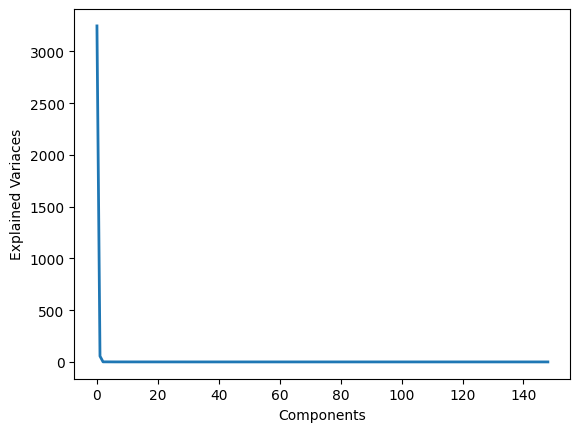

In [19]:
pca2 = PCA().fit(X)
plot(pca2.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variaces')
plt.show()

At around 2 components, the curve starts to stabilize. So, we'll use 2 components for PCA

In [20]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [21]:
print(f"X Train shape: {X_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"y Test shape: {y_test.shape}")

X Train shape: (297, 2)
X Test shape: (75, 2)
y Train shape: (297,)
y Test shape: (75,)


In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate performance
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression after PCA: RMSE = {rmse:.4f}, R² Score = {r2:.4f}")

Linear Regression after PCA: RMSE = 0.0623, R² Score = 0.1053


In [23]:
y_train.shape

(297,)

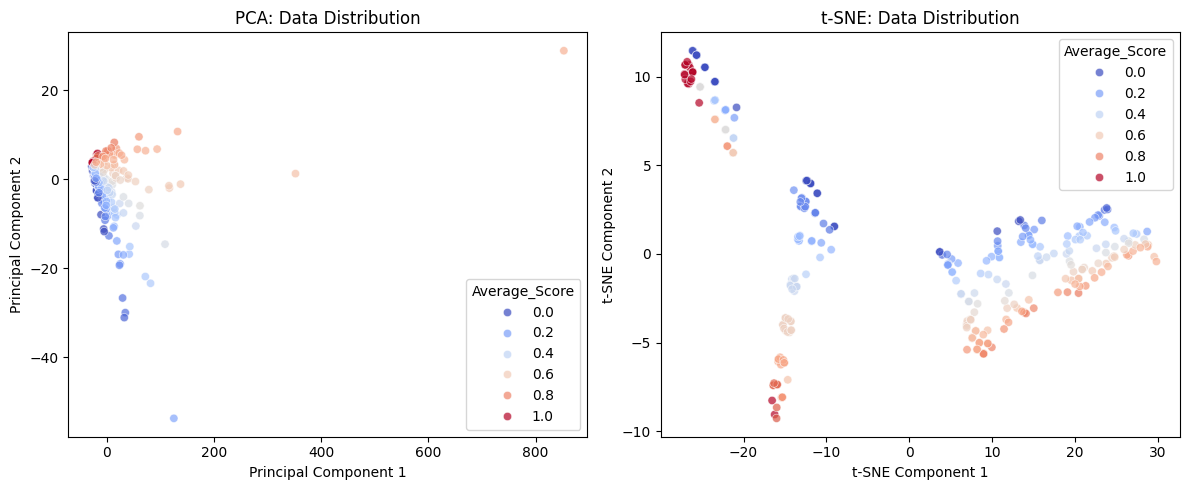

In [24]:
# Reduce to 2D using t-SNE (captures complex structure)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train)
X_tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_train)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y_train, palette="coolwarm", alpha=0.7)
plt.title("PCA: Data Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y_train, palette="coolwarm", alpha=0.7)
plt.title("t-SNE: Data Distribution")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

- The PCA1 and PCA2 don't clearly separate scores, suggesting that the features don't really strongly correleate in a linear way. This is the reason, why the Linear Regression didn't perform at par.
- This suggests that the Nonlinear models might perform better, which is evident from the RFR, GBR and XGB (the best).
- The tSNE plot does show some level of separation into clusters, if we look at the average scores. This suggests the feature similarity for the expected average score values. This is a very strong evidence, why the XGBoost worked better - it's linear and uses the Ensemble Boosting strategy. Also we did observe that the RandomForest also does decent. So Non-Linear models will always perform good on this data.